
<h1 align="center"> A study on Fraud Detection for Credit Card Transactions:  </h1>

<h4 align = "center"> by Abhay Narayanan </h4>

In [39]:
# Standard Imported Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Relevant Classifiers
from sklearn.linear_model import LogisticRegression

# Other Libraries
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
import warnings

# Measure Libraries
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score 
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve


The data is available at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data.


<h3>Taking a look at the data:</h3>

This includes viewing a snapshot of the dataframe (where each row represents one distinct transaction), checking its shape, and other such properties and statistics. 

From below, coupled with the online data description (available on the Kaggle link to the data) we see that the dataset has undergone a PCA transformation for all features except for the Time and Amount features. This has been done to preserve anonymity and to ensure data privacy. 

The Time feature refers to the amount of time since the first transaction/first row and the Amount feature refers to the amount corresponding to the transaction in question. 

In [25]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Below, we get some general information such as the exact shape of the data frame and a breakdown on value types by column. This tells us that there are 284807 transactions (rows) and 31 columns, out of which 28 are the PCA-scaled and reduced features, with the others being Time, Amount, and class (1 representing a fraud transaction and 0 representing a non-fraud transaction). 

In [26]:
print("Shape of Dataframe:", df.shape, "\n", "----"*25)
df.info()

Shape of Dataframe: (284807, 31) 
 ----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  f

The command below gives us some statistics on our data, giving us our first hint about the distribution on factors such as what range of times the transactions are in, how large transactions are, and whether transactions are typically fraudulent or not. 

In [27]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Below we check whether or not we have null values in our dataset. We find that there are none, meaning that we don't have to account for missing data.

In [28]:
sum(df.isnull().sum())

0

The code below tells us for reference the number of transactions, and consequently how many of those are fraudulent and non-fraudulent with the help of the Class column.

In [29]:
print("Number of Transactions (Same as size of Dataset):", len(df))
print('Number of Transactions classed "Non-fraud":', df['Class'].value_counts()[0], "(", round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset', ")")
print('Number of Transactions classed "Fraud":', df['Class'].value_counts()[1], "(", round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset', ")")

Number of Transactions (Same as size of Dataset): 284807
Number of Transactions classed "Non-fraud": 284315 ( 99.83 % of the dataset )
Number of Transactions classed "Fraud": 492 ( 0.17 % of the dataset )


The cell below uses the values found before to create a pie chart to easily visualize the split of the fraudulent (orange) vs non-fraudulent (blue) transactions in the dataset. 

The visualization, coupled with the percentages from the output above tell us how skewed this dataset is; it is mostly comprised of non-fraudulent transactions, with very few that are fraudulent. 

In cases where the dataset is so skewed, measures have to be taken to ensure that the trained model does not overfit and simply classify any given transacrtion as "non-fraudulent" simply to maintain a high accuracy. 

This problem will be evaluated momentarily.

([<matplotlib.patches.Wedge at 0x7fb4a6f37460>,
 [Text(-1.1999823287674471, 0.006512345649200875, '0'),
  Text(1.199982329255704, -0.006512255681064682, '1')])

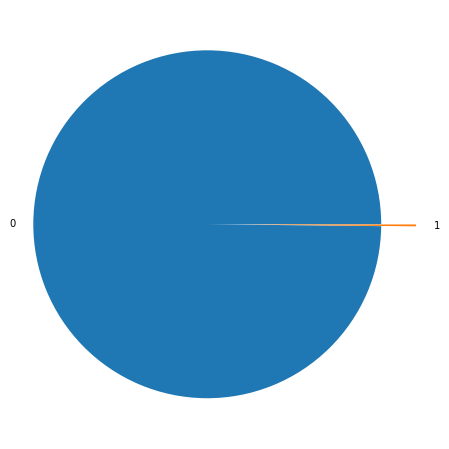

In [30]:
index = df['Class'].value_counts().index
values = df['Class'].value_counts().values

plt.figure(figsize=(8, 8))
plt.pie(values, labels = index, explode = [0.1] * len(index))

<h3> Completely Scaling the Data: </h3>

Here, considering the columns V1,..., V28 are all scaled with respect to themselves and to each other. However, the Time and Amount are not. As such, we must first scale them so that they are comparable to the other features in order to ensure that the model we train is not unduly affected by one feature. 

This is of particular importance considering the amount and time are measured by completely different units. 

As such, the code below first reshapes them into a more compatible shape then uses the RobustScaler method to get our new features (scaled_amount, scaled_time) that we can use for classification.


A note on using RobustScaler instead of the more typical StandardScaler: 


RobustScaler is less prone than StandardScaler to outliers drastically affecting the feature vector. 

This is because RobustScaler is computed using the median and IQR values while StandardScaler computes the scaled vector using the mean and standard deviation, which is far more sensitive to change by extreme values. 

In [31]:
reshaped_amount = df['Amount'].values.reshape(-1,1)
reshaped_time = df['Time'].values.reshape(-1,1)

# These two new columns are at the end of the data frame.
df['scaled_amount'] = RobustScaler().fit_transform(reshaped_amount)
df['scaled_time'] = RobustScaler().fit_transform(reshaped_time)

# Get rid of the now unused Time and Amount features
df.drop(['Time', 'Amount'], axis = 1, inplace = True) 

df.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.269825,-0.994983
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,4.983721,-0.994972
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,1.418291,-0.994972
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.670579,-0.994960


<h3> Training and Viewing Model Performance </h3>

<h4> This section also includes: </h4>
<h5> 1) Balancing & Splitting the Data </h5>

<h5> 2) Design Considerations </h5>

Here, we begin fixing the issue of the imbalanced dataset (an overwhelming majority of the transactions are not fraudulent). This can be fixed, and made into a balanced dataset, in two reasonably intuitive ways: 

1) We can remove enough non-fraudulent transactions until both classes have the same amount of data. 
2) We can create "fake data" to create new transactions that are fraudulent until both classes have the same amount of data. 

In this investigation, we can safely decide that option 1 would likely result in a model that is not as accurate as it could be due to the large information loss in what makes a transaction non-fraudulent. This is because we would be trimming down 284315 transactions into a mere 492 transactions. It is also a difficult matter to appropriately decide which transactions to trim. 

As such, we are left with the second method, which is known as SMOTE (Synthetic Minority Over-sampling Technique). This would be better because we don't deal with an information loss, and arm ourselves with a greater amount of training data for our classifier. 

However, an issue with this choice is that it would be significantly slower than the first method due to retaining all those transactions, despite any redundancies.


Note: Remember that we must split the data first before applying SMOTE. Otherwise, we would be using our validation set would be partly comprised of, or even be predominantly data that we manufactured using our SMOTE method! 


Consequently, splitting the dataset first and keeping our validation data aside will ensure that we can then safely make our "fake" data to be part of our training set.

In [41]:
# Create empty lists to hold our metrics
f1_list = []
rec_list = []

acc_list = []
prec_list = []
roc_list = []

warnings.filterwarnings('ignore')

# Create set of parameters for RandomizedSearchCV to decide from
parameters = {"penalty":['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

find_opt_params = RandomizedSearchCV(LogisticRegression(), parameters, n_iter=4)

X = df.drop('Class', axis=1) # Data frame without class results
y = df['Class'] # Only Class column for use in skf.split

# Splitting the data
skf = StratifiedKFold(n_splits=5)

for i, j in skf.split(X, y):
    original_Xtrain, original_Xtest = X.iloc[i], X.iloc[j]
    original_ytrain, original_ytest = y.iloc[i], y.iloc[j]


original_Xtrain = original_Xtrain.values # change these into arrays
original_ytrain = original_ytrain.values

original_Xtest = original_Xtest.values
original_ytest = original_ytest.values


for train, test in skf.split(original_Xtrain, original_ytrain): 
    pipe = make_pipeline(SMOTE(sampling_strategy='minority'), find_opt_params)
    model = pipe.fit(original_Xtrain[train], original_ytrain[train])
    use_opt_params = find_opt_params.best_estimator_
    predict_tr = use_opt_params.predict(original_Xtrain[test])
    
    
    f1_list.append(f1_score(original_ytrain[test], predict_tr))
    rec_list.append(recall_score(original_ytrain[test], predict_tr))
    
    acc_list.append(pipe.score(original_Xtrain[test], original_ytrain[test]))
    prec_list.append(precision_score(original_ytrain[test], predict_tr))
    roc_list.append(roc_auc_score(original_ytrain[test], predict_tr))
    
print("---" * 25)


print("f1:", np.mean(f1_list))
print("recall:", np.mean(rec_list))

print("accuracy:", np.mean(acc_list))
print("precision:", np.mean(prec_list))
print("roc:", np.mean(roc_list))

print("---" * 25)


---------------------------------------------------------------------------
f1: 0.10885704172435237
recall: 0.9111976630963973
accuracy: 0.9419526726195431
precision: 0.058849215669847424
roc: 0.9266017612148734
---------------------------------------------------------------------------


Here, we simply generate a classification report given our predicted classes through SMOTE compared with the actual classes given in the dataset. 

In [52]:
class_labels = ['Non-Fraudulent Transactions', 'Fraudulent Transactions']
final_pred = use_opt_params.predict(original_Xtest)

print(classification_report(y_pred= final_pred, y_true= original_ytest, target_names=class_labels))

                             precision    recall  f1-score   support

Non-Fraudulent Transactions       1.00      0.99      0.99     56863
    Fraudulent Transactions       0.09      0.86      0.17        98

                   accuracy                           0.99     56961
                  macro avg       0.55      0.92      0.58     56961
               weighted avg       1.00      0.99      0.99     56961



Here we get the Precision-Recall Average Score, which tells us how well the model performs across all thresholds. This is the area under the following curve.

In [59]:
dec_scores = use_opt_params.decision_function(original_Xtest)

avg_precision = average_precision_score(original_ytest, dec_scores)

print('Precision-Recall Average Scores {0:0.2f}'.format(avg_precision))

Precision-Recall Average Scores 0.70


Here, we plot the Precision-Recall curve, showing us how the precision value reacts at each recall threshold. It essentially depicts the precision-recall trade-off. 

Text(0.5, 1.0, 'SMOTE Method Precision-Recall curve')

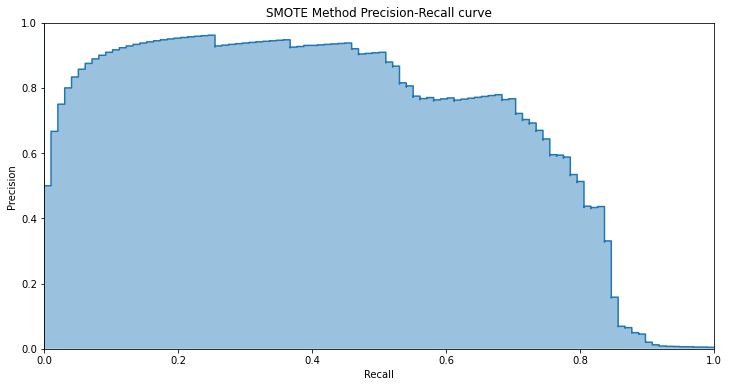

In [93]:
fig = plt.figure(figsize=(12,6))

prec, rec, _ = precision_recall_curve(original_ytest, dec_scores)

plt.step(x = rec, y = prec, alpha=1, where='post')
plt.fill_between(x = rec, y1 = 0, y2 = prec, alpha=0.45, step='post')

plt.ylabel('Precision')
plt.xlabel('Recall')

plt.ylim([0, 1])
plt.xlim([0, 1])

plt.title('SMOTE Method Precision-Recall curve')